<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/Training_Freezing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download Image and Trained Model

In [1]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
# id = ['18A9mAt9r4CoXLeoCK2muPNvIEqVKvOaw']
id = ['1pZgspfWi1Mh8sqV_lbJLQTuFZyhnTPlA']
downloaded = drive.CreateFile({'id':id[0]}) 
downloaded.GetContentFile('localization_2.zip')
!unzip localization_2.zip

Archive:  localization_2.zip
  inflating: localization/001202.png  
  inflating: localization/001203.png  
  inflating: localization/1_frame132.png  
  inflating: localization/1_frame146.png  
  inflating: localization/16_frame119.png  
  inflating: localization/16_frame122.png  
  inflating: localization/5_frame078.png  
  inflating: localization/5_frame118.png  
  inflating: localization/combine_miccai18_ResNet50_256,320_170_best_checkpoint.pth.tar  
  inflating: localization/raw_image.png  


ResNet

In [2]:
import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url


__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152', 'resnext50_32x4d', 'resnext101_32x8d',
           'wide_resnet50_2', 'wide_resnet101_2']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
    'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
    'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
    'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
}


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x_layer4_out = x.clone()
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x, x_layer4_out


def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def resnet18(pretrained=False, progress=True, **kwargs):
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)


def resnet34(pretrained=False, progress=True, **kwargs):
    r"""ResNet-34 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet34', BasicBlock, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet50(pretrained=False, progress=True, **kwargs):
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet101(pretrained=False, progress=True, **kwargs):
    r"""ResNet-101 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet101', Bottleneck, [3, 4, 23, 3], pretrained, progress,
                   **kwargs)


def resnet152(pretrained=False, progress=True, **kwargs):
    r"""ResNet-152 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet152', Bottleneck, [3, 8, 36, 3], pretrained, progress,
                   **kwargs)


def resnext50_32x4d(pretrained=False, progress=True, **kwargs):
    r"""ResNeXt-50 32x4d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 4
    return _resnet('resnext50_32x4d', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)


def resnext101_32x8d(pretrained=False, progress=True, **kwargs):
    r"""ResNeXt-101 32x8d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 8
    return _resnet('resnext101_32x8d', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)


def wide_resnet50_2(pretrained=False, progress=True, **kwargs):
    r"""Wide ResNet-50-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_

    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet50_2', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)


def wide_resnet101_2(pretrained=False, progress=True, **kwargs):
    r"""Wide ResNet-101-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_

    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet101_2', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)

Fix seed to get result reproducibility

In [3]:
import random
import torch
import numpy as np
import os

def seed_everything(seed=42):
  random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  np.random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

seed_everything()

# Single Pass GradCAM

In [9]:
import torch 
import torch.nn.functional as F

def reg_hook_gradcam(last_conv_layer=None):
    # gradients for gradcam are stored here
    stored_grads = torch.Tensor([])
    stored_fpass = torch.Tensor([])

    def bpass_hook(self, gin, gout):
        global stored_grads
        stored_grads = gout

    def fpass_hook(self, ten_in, ten_out):
        global stored_fpass
        stored_fpass = ten_out

    # register hooks for gradCAM model.layer4[-1].conv1
    #last_conv_layer = model.model.features.denseblock4.denselayer16.conv2
    #last_conv_layer = model.layer4[2].conv3
    #last_conv_layer = model.layer4[-1].conv1
    handle_b = last_conv_layer.register_backward_hook(bpass_hook)
    handle_f = last_conv_layer.register_forward_hook(fpass_hook)

def gradcam_pp(grads, activations):
    grads_power_2 = grads**2
    grads_power_3 = grads_power_2 * grads
    # Equation 19 in https://arxiv.org/abs/1710.11063
    sum_activations = torch.sum(activations, dim=[ 2, 3])
    eps = 0.000001
    aij = grads_power_2 / (2 * grads_power_2 +
                            sum_activations[:, :, None, None] * grads_power_3 + eps)
    # Now bring back the ReLU from eq.7 in the paper,
    # And zero out aijs where the activations are 0
    aij = torch.where(grads != 0, aij, 0)

    weights = torch.maximum(grads, torch.tensor(0)) * aij
    weights = torch.sum(weights, dim=[ 2, 3])
    return weights

def get_gradcam(model, img, lab=None, gradcampp=False):
    model.eval()
    last_conv_layer = model.layer4[2].conv3
    reg_hook_gradcam(last_conv_layer=last_conv_layer)
    out, feature_map = model(img)
    out = torch.sigmoid(out)
    #pred_labels = torch.argwhere(out>0.5)[1]
    pred_labels = torch.argwhere(out.detach().squeeze()>0.5)
    print('Probability:',[round(tl.item(), 3) for tl in out.squeeze()],'\nPredictions:', [pl.item() for pl in pred_labels.squeeze()])
    pred_onehot = F.one_hot(pred_labels, num_classes=11)
    feature_map_all = []
    for pred_onehot_each in pred_onehot:
        out.backward(pred_onehot_each, retain_graph=True)
        gradients = stored_grads[0].clone()
        activations = stored_fpass[0].clone().unsqueeze(0)
        activations = activations.detach()
        if gradcampp:
            pooled_gradients = gradcam_pp(gradients, activations)
        else:
            pooled_gradients = torch.mean(gradients, dim=[2, 3])
        activations *= pooled_gradients[:,:,None, None]

        # for j in range(gradients.shape[1]):
        #     activations[:, j, :, :] *= pooled_gradients[j]

        heatmap = torch.sum(activations, dim=1).squeeze().cpu()
        heatmap = np.maximum(heatmap, 0)
        heatmap /= torch.max(heatmap)
        hmap = heatmap.numpy()
        hmap[hmap<0.60] = 0
        hmap_rep = hmap[None].repeat(2048, axis=0)
        feature_map_class = feature_map.squeeze()[hmap_rep>0]
        feature_map_class_final = F.adaptive_avg_pool1d(torch.tensor(feature_map_class[None]),[512])
        feature_map_all.append(feature_map_class_final)

    return torch.stack(feature_map_all), pred_labels


# End-to-End GCN

In [10]:
import torch.nn as nn
from PIL import Image
from torchvision import transforms as tf
import torch.optim as optim

class GadientBased_MCC(nn.Module):
    def __init__(self, num_classes=11, checkpoint_path=None):
        super(GadientBased_MCC, self).__init__()
        self.GradientModel = resnet50(pretrained=True)
        self.GradientModel.fc = nn.Linear(self.GradientModel.fc.in_features, num_classes) 
        self.GradientModel = nn.DataParallel(self.GradientModel)
        self.GradientModel.load_state_dict(torch.load(checkpoint_path))
        self.GradientModel = self.GradientModel.module
        self.GradientModel.eval()
        self.mcc = nn.Linear(512, num_classes)
    
    def forward(self, x):
        feature_map_all, pred_labels = get_gradcam(self.GradientModel, x, gradcampp=True)
        
        out = self.mcc(feature_map_all)
        return out

def freeze_module(model_mcc):
    for name, param in model_mcc.GradientModel.named_parameters():
        if param.requires_grad:
            if name.split('.')[1].isdigit():
                name = name.replace('.{}.'.format(name.split('.')[1]),'[{}].'.format(name.split('.')[1]))
                if name.split('.')[2].isdigit():
                    name = name.replace('.{}.'.format(name.split('.')[2]),'[{}].'.format(name.split('.')[2]))

            my_code = 'model_mcc.GradientModel.'+ name + '.register_hook(lambda grad:grad.mul_(0))'
            exec(my_code)

checkpoint_path = 'localization/combine_miccai18_ResNet50_256,320_170_best_checkpoint.pth.tar'     
model_mcc = GadientBased_MCC(num_classes=11, checkpoint_path=checkpoint_path).cuda()

image = Image.open("localization/1_frame146.png").convert('RGB')
transforms = tf.Compose([tf.Resize((256,320)), 
                        tf.ToTensor(),
                        tf.Normalize([0.4084945, 0.25513682, 0.25353566], [0.22662906, 0.20201652, 0.1962526 ])])

img = transforms(image).cuda()
#out = model_mcc(img[None]).cuda()
lab = torch.tensor([0,3,5,10]).cuda()
optimizer = optim.SGD(model_mcc.parameters(), lr=0.1, momentum=0.9, nesterov=False, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()

freeze_module(model_mcc)

for i in range(2):
    print('GradientModel.conv1.weight:',model_mcc.GradientModel.conv1.weight[0,0,0])
    out = model_mcc(img[None])
    loss = criterion(out.squeeze(), lab)
    print('loss', loss.item())
    loss.backward()
    optimizer.step()

print(out.shape)

GradientModel.conv1.weight: tensor([ 0.0145,  0.0153, -0.0132, -0.0206, -0.0370, -0.0391, -0.0651],
       device='cuda:0', grad_fn=<SelectBackward0>)
Probability: [0.999, 0.33, 0.016, 0.873, 0.002, 0.996, 0.006, 0.054, 0.0, 0.0, 1.0] 
Predictions: [0, 3, 5, 10]


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


loss 2.7677981853485107
GradientModel.conv1.weight: tensor([ 0.0145,  0.0153, -0.0132, -0.0206, -0.0370, -0.0391, -0.0651],
       device='cuda:0', grad_fn=<SelectBackward0>)
Probability: [0.999, 0.329, 0.016, 0.873, 0.002, 0.996, 0.006, 0.054, 0.0, 0.0, 1.0] 
Predictions: [0, 3, 5, 10]
loss 1.8433572053909302
torch.Size([4, 1, 11])


# Ablation Study

In [ ]:
import torch.nn as nn
from torch.nn import DataParallel
import torch.nn.functional as F
from torchvision import transforms as tf
from PIL import Image
import matplotlib.pyplot as plt
import cv2

model = resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 11)
model = nn.DataParallel(model)
# model.to(device)
result_filename = 'combine_miccai18_ResNet50_256,320_170'
best_checkpoint_path = 'localization/' + result_filename + '_best_checkpoint.pth.tar'
checkpoint = torch.load(best_checkpoint_path, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint)
model = model.module
model.cuda();
model.eval()

image_name = "localization/1_frame146.png"   
classes = ['bipolar_forceps', 'prograsp_forceps', 'large_needle_driver', 'monopolar_curved_scissors', 'ultrasound_probe', 'suction', 'clip_applier', 'stapler', 'hook', 'specimen_bag', 'tissue']

'''------------------------------------- Load image ------------------------------------'''
image = Image.open(image_name).convert('RGB')
transforms = tf.Compose([tf.Resize((256,320)), 
                        tf.ToTensor(),
                        tf.Normalize([0.4084945, 0.25513682, 0.25353566], [0.22662906, 0.20201652, 0.1962526 ])])

img = transforms(image).cuda()

out, feature_map = model(img[None])
out = torch.sigmoid(out)
#pred_labels = torch.argwhere(out>0.5)[1]
pred_labels = torch.argwhere(out.detach().squeeze()>0.5)
print('pred_labels', pred_labels)


pred_labels tensor([[ 0],
        [ 3],
        [ 5],
        [10]], device='cuda:0')


# GradCam Single Pass:

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


feature_map: torch.Size([1, 2048, 8, 10])
feature_map_pooled: (8, 10)
Probability: [0.999, 0.33, 0.016, 0.873, 0.002, 0.996, 0.006, 0.054, 0.0, 0.0, 1.0]
Labels: [0, 3, 5, 10] Predictions: [0, 3, 5, 10]
pooled_gradients torch.Size([2048])
activation torch.Size([1, 2048, 8, 10])
min max tensor(0.) tensor(1.) shape: torch.Size([8, 10])
hmap (8, 10) feature_map_pooled (8, 10) 1.0669733 0.12845543
feature_map_class: (5,)
feature_map_class_final: torch.Size([1, 512])
pooled_gradients torch.Size([2048])
activation torch.Size([1, 2048, 8, 10])
min max tensor(0.) tensor(1.) shape: torch.Size([8, 10])
hmap (8, 10) feature_map_pooled (8, 10) 1.0669733 0.12845543
feature_map_class: (7,)
feature_map_class_final: torch.Size([1, 512])
pooled_gradients torch.Size([2048])
activation torch.Size([1, 2048, 8, 10])
min max tensor(0.) tensor(1.) shape: torch.Size([8, 10])
hmap (8, 10) feature_map_pooled (8, 10) 1.0669733 0.12845543
feature_map_class: (7,)
feature_map_class_final: torch.Size([1, 512])
poole

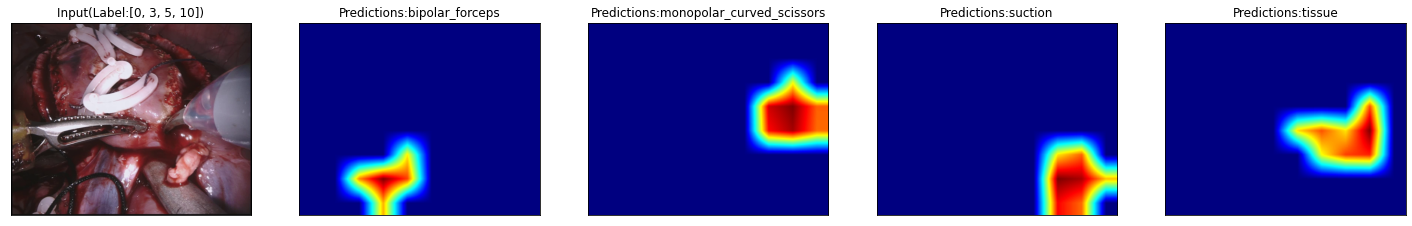

In [ ]:
import torch.nn as nn
from torch.nn import DataParallel
import torch.nn.functional as F
from torchvision import transforms as tf
from PIL import Image
import matplotlib.pyplot as plt
import cv2
#from torchvision import models

def reg_hook_gradcam():
    # gradients for gradcam are stored here
    stored_grads = torch.Tensor([])
    stored_fpass = torch.Tensor([])

    def bpass_hook(self, gin, gout):
        global stored_grads
        stored_grads = gout

    def fpass_hook(self, ten_in, ten_out):
        global stored_fpass
        stored_fpass = ten_out

    # register hooks for gradCAM model.layer4[-1].conv1
    #last_conv_layer = model.model.features.denseblock4.denselayer16.conv2
    last_conv_layer = model.layer4[2].conv3
    #last_conv_layer = model.layer4[-1].conv1
    handle_b = last_conv_layer.register_backward_hook(bpass_hook)
    handle_f = last_conv_layer.register_forward_hook(fpass_hook)


def get_gradcam(model, img, lab):
    reg_hook_gradcam()
    out, feature_map = model(img)
    out, feature_map = out.cpu(), feature_map.cpu()
    print('feature_map:',feature_map.shape)
    feature_map_pooled = F.adaptive_avg_pool3d(feature_map, [1,8,10]).squeeze().detach().numpy()
    print('feature_map_pooled:',feature_map_pooled.shape)
    out = torch.sigmoid(out)
    true_labels = np.argwhere(lab.cpu()==1)[1]
    pred_labels = np.argwhere(out.cpu()>0.5)[1]
    print('Probability:',[round(pro.item(), 3) for pro in out.squeeze()])
    print('Labels:',[tl.item() for tl in true_labels],'Predictions:', [pl.item() for pl in pred_labels])
    pred_lab_each = []
    for ii in pred_labels:
        backward_arg = torch.zeros(1,11)
        backward_arg[0,ii] = 1
        pred_lab_each.append(backward_arg)

    #a = pred_lab_each[0]
    img_hmap = np.transpose(img.squeeze().cpu().numpy(),(1,2,0))
    supim_all = []
    heatmap_all = []
    feature_maps_all = []
    for a in pred_lab_each:
        out.backward(a, retain_graph=True)
        gradients = stored_grads[0].clone()
        activations = stored_fpass[0].clone().unsqueeze(0)
        activations = activations.detach()

        pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
        print('pooled_gradients', pooled_gradients.shape)
        for j in range(gradients.shape[1]):
            activations[:, j, :, :] *= pooled_gradients[j]

        print('activation', activations.shape)
        heatmap = torch.sum(activations, dim=1).squeeze().cpu()
        heatmap = np.maximum(heatmap, 0)
        heatmap /= torch.max(heatmap)
        print('min max', heatmap.min(), heatmap.max(), 'shape:', heatmap.shape)

        hmap = heatmap.numpy()
        hmap[hmap<0.60] = 0
        print('hmap',hmap.shape, 'feature_map_pooled',feature_map_pooled.shape, feature_map_pooled.max(), feature_map_pooled.min())
        feature_map_class = feature_map_pooled[hmap>0] #then pooling to 512
        print('feature_map_class:',feature_map_class.shape)
        feature_map_class_final = F.adaptive_avg_pool1d(torch.tensor(feature_map_class[None]),[512])
        print('feature_map_class_final:',feature_map_class_final.shape)
        feature_map_2d = feature_map_pooled.copy()
        feature_map_2d[hmap==0] = 0
        feature_map_2d_resized = cv2.resize(feature_map_2d, (img_hmap.shape[1], img_hmap.shape[0]))
        feature_maps_all.append(feature_map_2d_resized)

        heatmap1 = cv2.resize(hmap, (img_hmap.shape[1], img_hmap.shape[0]))
        heatmap1 = np.uint8(-255 * heatmap1 + 255)
        heatmap1 = cv2.applyColorMap(heatmap1, cv2.COLORMAP_JET)
        heatmap_all.append(heatmap1)
    return heatmap_all, pred_labels, true_labels, feature_maps_all, feature_map_class_final

model = resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 11)
model = DataParallel(model)
# model.to(device)
result_filename = 'combine_miccai18_ResNet50_256,320_170'
best_checkpoint_path = 'localization/' + result_filename + '_best_checkpoint.pth.tar'
checkpoint = torch.load(best_checkpoint_path, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint)
model = model.module
model.cuda();
model.eval()

for name, param in model.named_parameters():
    if param.requires_grad:
        if name.split('.')[1].isdigit():
            name = name.replace('.{}.'.format(name.split('.')[1]),'[{}].'.format(name.split('.')[1]))
            if name.split('.')[2].isdigit():
                name = name.replace('.{}.'.format(name.split('.')[2]),'[{}].'.format(name.split('.')[2]))

        my_code = 'model.'+ name + '.register_hook(lambda grad:grad.mul_(0))'
        exec(my_code)

image_name = "localization/1_frame146.png"   
classes = ['bipolar_forceps', 'prograsp_forceps', 'large_needle_driver', 'monopolar_curved_scissors', 'ultrasound_probe', 'suction', 'clip_applier', 'stapler', 'hook', 'specimen_bag', 'tissue']

'''------------------------------------- Load image ------------------------------------'''
image = Image.open(image_name).convert('RGB')
transforms = tf.Compose([tf.Resize((256,320)), 
                        tf.ToTensor(),
                        tf.Normalize([0.4084945, 0.25513682, 0.25353566], [0.22662906, 0.20201652, 0.1962526 ])])

img = transforms(image).cuda()
lab = torch.tensor([1,0,0,1,0,1,0,0,0,0,1])
img, lab = img[None], lab[None]
heatmap_all, pred_labels, true_labels, feature_maps_all, feature_map_class_final = get_gradcam(model, img, lab)

num_img = len(heatmap_all)+1
fig, ax = plt.subplots(1, num_img, figsize=(5*num_img,5), subplot_kw=dict(xticks=[],yticks=[]))
#ax[0].imshow(img[0].detach().permute(1,2,0).cpu())
ax[0].imshow(image)
ax[0].set_title('Input(Label:{})'.format([tl.item() for tl in true_labels]))

for idx, heatmap in enumerate(heatmap_all):
    ax[idx+1].imshow(heatmap)
    ax[idx+1].set_title('Predictions:{}'.format([classes[pl.item()] for pl in pred_labels][idx]))


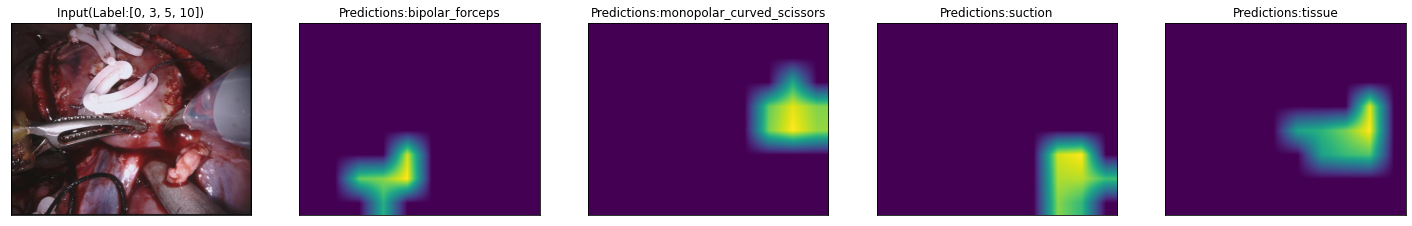

In [ ]:
fig, ax = plt.subplots(1, num_img, figsize=(5*num_img,5), subplot_kw=dict(xticks=[],yticks=[]))
#ax[0].imshow(img[0].detach().permute(1,2,0).cpu())
ax[0].imshow(image)
ax[0].set_title('Input(Label:{})'.format([tl.item() for tl in true_labels]))

for idx, featuremap in enumerate(feature_maps_all):
    ax[idx+1].imshow(featuremap)
    ax[idx+1].set_title('Predictions:{}'.format([classes[pl.item()] for pl in pred_labels][idx]))

# Single Pass GradCAM++

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get th

Probability: [0.999, 0.33, 0.016, 0.873, 0.002, 0.996, 0.006, 0.054, 0.0, 0.0, 1.0]
Labels: [0, 3, 5, 10] Predictions: [0, 3, 5, 10]


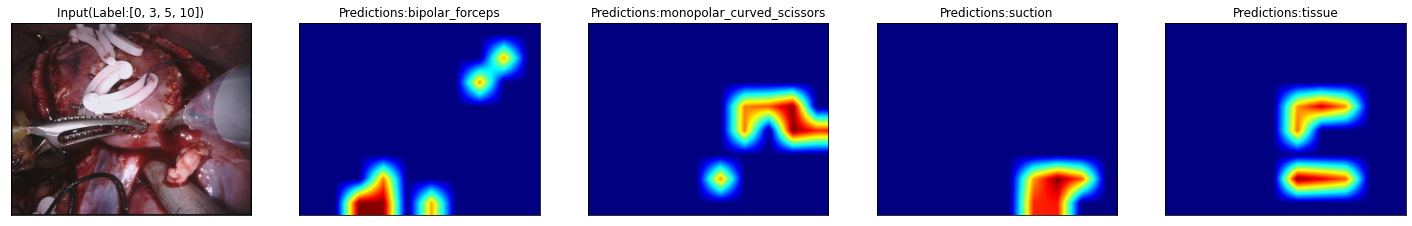

In [12]:
import torch.nn as nn
from torch.nn import DataParallel
import torch.nn.functional as F
from torchvision import transforms as tf
from PIL import Image
import matplotlib.pyplot as plt
import cv2

def reg_hook_gradcam():
    # gradients for gradcam are stored here
    stored_grads = torch.Tensor([])
    stored_fpass = torch.Tensor([])

    def bpass_hook(self, gin, gout):
        global stored_grads
        stored_grads = gout

    def fpass_hook(self, ten_in, ten_out):
        global stored_fpass
        stored_fpass = ten_out

    # register hooks for gradCAM model.layer4[-1].conv1
    #last_conv_layer = model.model.features.denseblock4.denselayer16.conv2
    #last_conv_layer = model.layer4[2].conv3
    last_conv_layer = model.layer4[-1].conv1
    handle_b = last_conv_layer.register_backward_hook(bpass_hook)
    handle_f = last_conv_layer.register_forward_hook(fpass_hook)

def gradcam_pp(grads, activations):
    grads_power_2 = grads**2
    grads_power_3 = grads_power_2 * grads
    # Equation 19 in https://arxiv.org/abs/1710.11063
    sum_activations = torch.sum(activations, dim=[ 2, 3])
    eps = 0.000001
    aij = grads_power_2 / (2 * grads_power_2 +
                            sum_activations[:, :, None, None] * grads_power_3 + eps)
    # Now bring back the ReLU from eq.7 in the paper,
    # And zero out aijs where the activations are 0
    aij = torch.where(grads != 0, aij, 0)

    weights = torch.maximum(grads, torch.tensor(0)) * aij
    weights = torch.sum(weights, dim=[ 2, 3])
    return weights

def get_gradcam(model, img, lab):
    reg_hook_gradcam()
    out = model(img).cpu()
    out = torch.sigmoid(out)
    true_labels = np.argwhere(lab.cpu()==1)[1]
    pred_labels = np.argwhere(out.cpu()>0.5)[1]
    print('Probability:',[round(pro.item(), 3) for pro in out.squeeze()])
    print('Labels:',[tl.item() for tl in true_labels],'Predictions:', [pl.item() for pl in pred_labels])
    pred_lab_each = []
    for ii in pred_labels:
        backward_arg = torch.zeros(1,11)
        backward_arg[0,ii] = 1
        pred_lab_each.append(backward_arg)

    #a = pred_lab_each[0]
    img_hmap = np.transpose(img.squeeze().cpu().numpy(),(1,2,0))
    supim_all = []
    heatmap_all = []
    for a in pred_lab_each:
        out.backward(a, retain_graph=True)
        gradients = stored_grads[0].clone()
        activations = stored_fpass[0].clone().unsqueeze(0)
        activations = activations.detach()

        #pooled_gradients = torch.mean(gradients, dim=[ 2, 3])
        pooled_gradients = gradcam_pp(gradients, activations)

        activations *= pooled_gradients[:,:,None, None]
        # for j in range(gradients.shape[1]):
        #     activations[:, j, :, :] *= pooled_gradients[j]

        heatmap = torch.sum(activations, dim=1).squeeze().cpu()
        heatmap = np.maximum(heatmap, 0)
        heatmap /= torch.max(heatmap)
        #print('min max', heatmap.min(), heatmap.max())
        hmap = heatmap.numpy()
        hmap[hmap<0.70] = 0
        heatmap1 = cv2.resize(hmap, (img_hmap.shape[1], img_hmap.shape[0]))
        heatmap1 = np.uint8(-255 * heatmap1 + 255)
        heatmap1 = cv2.applyColorMap(heatmap1, cv2.COLORMAP_JET)
        heatmap_all.append(heatmap1)
    return heatmap_all, pred_labels, true_labels

model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 11)
model = DataParallel(model)
# model.to(device)
result_filename = 'combine_miccai18_ResNet50_256,320_170'
best_checkpoint_path = 'localization/' + result_filename + '_best_checkpoint.pth.tar'
checkpoint = torch.load(best_checkpoint_path, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint)
model = model.module
model.cuda();
model.eval()

image_name = "localization/1_frame146.png"   
classes = ['bipolar_forceps', 'prograsp_forceps', 'large_needle_driver', 'monopolar_curved_scissors', 'ultrasound_probe', 'suction', 'clip_applier', 'stapler', 'hook', 'specimen_bag', 'tissue']

'''------------------------------------- Load image ------------------------------------'''
image = Image.open(image_name).convert('RGB')
transforms = tf.Compose([tf.Resize((256,320)), 
                        tf.ToTensor(),
                        tf.Normalize([0.4084945, 0.25513682, 0.25353566], [0.22662906, 0.20201652, 0.1962526 ])])

img = transforms(image).cuda()
lab = torch.tensor([1,0,0,1,0,1,0,0,0,0,1])
img, lab = img[None], lab[None]
heatmap_all, pred_labels, true_labels = get_gradcam(model, img, lab)

num_img = len(heatmap_all)+1
fig, ax = plt.subplots(1, num_img, figsize=(5*num_img,5), subplot_kw=dict(xticks=[],yticks=[]))
#ax[0].imshow(img[0].detach().permute(1,2,0).cpu())
ax[0].imshow(image)
ax[0].set_title('Input(Label:{})'.format([tl.item() for tl in true_labels]))

for idx, heatmap in enumerate(heatmap_all):
    ax[idx+1].imshow(heatmap)
    ax[idx+1].set_title('Predictions:{}'.format([classes[pl.item()] for pl in pred_labels][idx]))


# Tweaking the pooling layer

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


feature_map: torch.Size([1, 2048, 8, 10])
feature_map_pooled: (8, 10)
Probability: [0.999, 0.33, 0.016, 0.873, 0.002, 0.996, 0.006, 0.054, 0.0, 0.0, 1.0]
pooled_gradients torch.Size([2048])
activation torch.Size([1, 2048, 8, 10])
min max tensor(0.) tensor(1.) shape: torch.Size([8, 10])
hmap (8, 10) feature_map_pooled (8, 10) 1.0669733 0.12845543
feature_map_class: torch.Size([10240])
feature_map_class_final: torch.Size([1, 512])
feature_map_2d mean: torch.Size([8, 10])
pooled_gradients torch.Size([2048])
activation torch.Size([1, 2048, 8, 10])
min max tensor(0.) tensor(1.) shape: torch.Size([8, 10])
hmap (8, 10) feature_map_pooled (8, 10) 1.0669733 0.12845543
feature_map_class: torch.Size([14336])
feature_map_class_final: torch.Size([1, 512])
feature_map_2d mean: torch.Size([8, 10])
pooled_gradients torch.Size([2048])
activation torch.Size([1, 2048, 8, 10])
min max tensor(0.) tensor(1.) shape: torch.Size([8, 10])
hmap (8, 10) feature_map_pooled (8, 10) 1.0669733 0.12845543
feature_map_

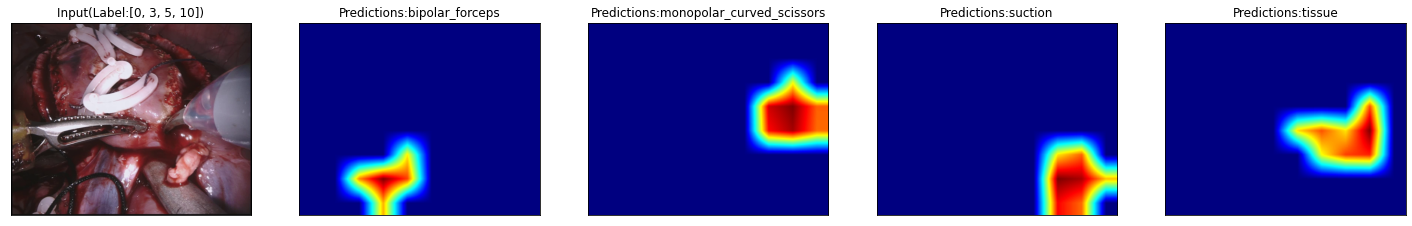

In [ ]:
import torch.nn as nn
from torch.nn import DataParallel
import torch.nn.functional as F
from torchvision import transforms as tf
from PIL import Image
import matplotlib.pyplot as plt
import cv2
#from torchvision import models

def reg_hook_gradcam():
    # gradients for gradcam are stored here
    stored_grads = torch.Tensor([])
    stored_fpass = torch.Tensor([])

    def bpass_hook(self, gin, gout):
        global stored_grads
        stored_grads = gout

    def fpass_hook(self, ten_in, ten_out):
        global stored_fpass
        stored_fpass = ten_out

    # register hooks for gradCAM model.layer4[-1].conv1
    #last_conv_layer = model.model.features.denseblock4.denselayer16.conv2
    last_conv_layer = model.layer4[2].conv3
    #last_conv_layer = model.layer4[-1].conv1
    handle_b = last_conv_layer.register_backward_hook(bpass_hook)
    handle_f = last_conv_layer.register_forward_hook(fpass_hook)


def get_gradcam(model, img, lab):
    reg_hook_gradcam()
    out, feature_map = model(img)
    out, feature_map = out.cpu(), feature_map.cpu()
    print('feature_map:',feature_map.shape)
    feature_map_pooled = F.adaptive_avg_pool3d(feature_map, [1,8,10]).squeeze().detach().numpy()
    print('feature_map_pooled:',feature_map_pooled.shape)
    feature_map = feature_map.squeeze()
    out = torch.sigmoid(out)
    true_labels = np.argwhere(lab.cpu()==1)[1]
    pred_labels = np.argwhere(out>0.5)[1]
    print('Probability:',[round(pro.item(), 3) for pro in out.squeeze()])
    #print('Labels:',[tl.item() for tl in true_labels],'Predictions:', [pl.item() for pl in pred_labels])
    pred_lab_each = F.one_hot(pred_labels, num_classes=11)
    #a = pred_lab_each[0]
    img_hmap = np.transpose(img.squeeze().cpu().numpy(),(1,2,0))
    supim_all = []
    heatmap_all = []
    feature_maps_all = []
    for a in pred_lab_each:
        #print(a.shape)
        out.backward(a[None], retain_graph=True)
        gradients = stored_grads[0].clone()
        activations = stored_fpass[0].clone().unsqueeze(0)
        activations = activations.detach()

        pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
        print('pooled_gradients', pooled_gradients.shape)
        for j in range(gradients.shape[1]):
            activations[:, j, :, :] *= pooled_gradients[j]

        print('activation', activations.shape)
        heatmap = torch.sum(activations, dim=1).squeeze().cpu()
        heatmap = np.maximum(heatmap, 0)
        heatmap /= torch.max(heatmap)
        print('min max', heatmap.min(), heatmap.max(), 'shape:', heatmap.shape)

        hmap = heatmap.numpy()
        hmap[hmap<0.60] = 0
        print('hmap',hmap.shape, 'feature_map_pooled',feature_map_pooled.shape, feature_map_pooled.max(), feature_map_pooled.min())
        hmap_rep = hmap[None].repeat(2048, axis=0)
        feature_map_class = feature_map[hmap_rep>0] #then pooling to 512
        print('feature_map_class:',feature_map_class.shape)
        feature_map_class_final = F.adaptive_avg_pool1d(torch.tensor(feature_map_class[None]),[512])
        print('feature_map_class_final:',feature_map_class_final.shape)
        feature_map_2d = feature_map.clone()
        feature_map_2d[hmap_rep==0] = 0
        feature_map_2d = feature_map_2d.mean(0)
        print('feature_map_2d mean:',feature_map_2d.shape)
        feature_map_2d_resized = cv2.resize(feature_map_2d.detach().numpy(), (img_hmap.shape[1], img_hmap.shape[0]))
        feature_maps_all.append(feature_map_2d_resized)
        # feature_map_2d = feature_map_pooled.copy()
        # feature_map_2d[hmap==0] = 0
        # feature_map_2d_resized = cv2.resize(feature_map_2d, (img_hmap.shape[1], img_hmap.shape[0]))
        # feature_maps_all.append(feature_map_2d_resized)

        heatmap1 = cv2.resize(hmap, (img_hmap.shape[1], img_hmap.shape[0]))
        heatmap1 = np.uint8(-255 * heatmap1 + 255)
        heatmap1 = cv2.applyColorMap(heatmap1, cv2.COLORMAP_JET)
        heatmap_all.append(heatmap1)
    return heatmap_all, pred_labels, true_labels, feature_maps_all, feature_map_class_final

model = resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 11)
model = DataParallel(model)
# model.to(device)
result_filename = 'combine_miccai18_ResNet50_256,320_170'
best_checkpoint_path = 'localization/' + result_filename + '_best_checkpoint.pth.tar'
checkpoint = torch.load(best_checkpoint_path, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint)
model = model.module
model.cuda();
model.eval()

for name, param in model.named_parameters():
    if param.requires_grad:
        if name.split('.')[1].isdigit():
            name = name.replace('.{}.'.format(name.split('.')[1]),'[{}].'.format(name.split('.')[1]))
            if name.split('.')[2].isdigit():
                name = name.replace('.{}.'.format(name.split('.')[2]),'[{}].'.format(name.split('.')[2]))

        my_code = 'model.'+ name + '.register_hook(lambda grad:grad.mul_(0))'
        exec(my_code)

image_name = "localization/1_frame146.png"   
classes = ['bipolar_forceps', 'prograsp_forceps', 'large_needle_driver', 'monopolar_curved_scissors', 'ultrasound_probe', 'suction', 'clip_applier', 'stapler', 'hook', 'specimen_bag', 'tissue']

'''------------------------------------- Load image ------------------------------------'''
image = Image.open(image_name).convert('RGB')
transforms = tf.Compose([tf.Resize((256,320)), 
                        tf.ToTensor(),
                        tf.Normalize([0.4084945, 0.25513682, 0.25353566], [0.22662906, 0.20201652, 0.1962526 ])])

img = transforms(image).cuda()
lab = torch.tensor([1,0,0,1,0,1,0,0,0,0,1])
img, lab = img[None], lab[None]
heatmap_all, pred_labels, true_labels, feature_maps_all, feature_map_class_final = get_gradcam(model, img, lab)

num_img = len(heatmap_all)+1
fig, ax = plt.subplots(1, num_img, figsize=(5*num_img,5), subplot_kw=dict(xticks=[],yticks=[]))
#ax[0].imshow(img[0].detach().permute(1,2,0).cpu())
ax[0].imshow(image)
ax[0].set_title('Input(Label:{})'.format([tl.item() for tl in true_labels]))

for idx, heatmap in enumerate(heatmap_all):
    ax[idx+1].imshow(heatmap)
    ax[idx+1].set_title('Predictions:{}'.format([classes[pl.item()] for pl in pred_labels][idx]))


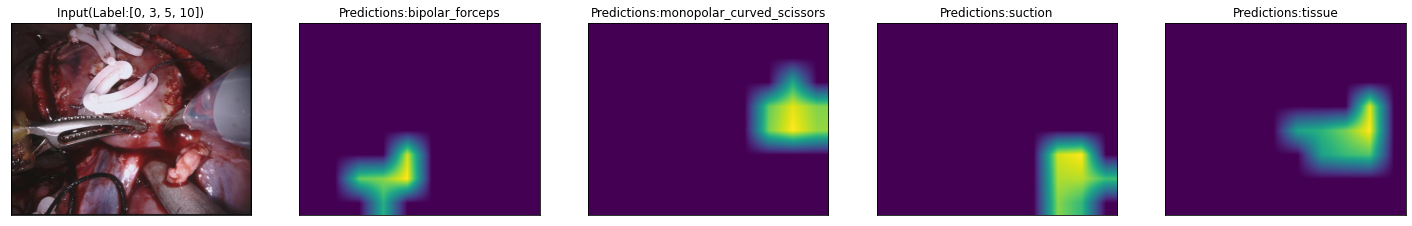

In [ ]:
fig, ax = plt.subplots(1, num_img, figsize=(5*num_img,5), subplot_kw=dict(xticks=[],yticks=[]))
#ax[0].imshow(img[0].detach().permute(1,2,0).cpu())
ax[0].imshow(image)
ax[0].set_title('Input(Label:{})'.format([tl.item() for tl in true_labels]))

for idx, featuremap in enumerate(feature_maps_all):
    ax[idx+1].imshow(featuremap)
    ax[idx+1].set_title('Predictions:{}'.format([classes[pl.item()] for pl in pred_labels][idx]))

# GradCam Variations

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


feature_map: torch.Size([1, 2048, 8, 10])
feature_map_pooled: (8, 10)
Probability: [0.999, 0.33, 0.016, 0.873, 0.002, 0.996, 0.006, 0.054, 0.0, 0.0, 1.0]
pooled_gradients torch.Size([2048])
activation torch.Size([1, 2048, 8, 10])
min max tensor(0.) tensor(1.) shape: torch.Size([8, 10])
hmap (8, 10) feature_map_pooled (8, 10) 1.0669733 0.12845543
feature_map_class: torch.Size([10240])
feature_map_class_final: torch.Size([1, 512])
feature_map_2d mean: torch.Size([8, 10])
pooled_gradients torch.Size([2048])
activation torch.Size([1, 2048, 8, 10])
min max tensor(0.) tensor(1.) shape: torch.Size([8, 10])
hmap (8, 10) feature_map_pooled (8, 10) 1.0669733 0.12845543
feature_map_class: torch.Size([14336])
feature_map_class_final: torch.Size([1, 512])
feature_map_2d mean: torch.Size([8, 10])
pooled_gradients torch.Size([2048])
activation torch.Size([1, 2048, 8, 10])
min max tensor(0.) tensor(1.) shape: torch.Size([8, 10])
hmap (8, 10) feature_map_pooled (8, 10) 1.0669733 0.12845543
feature_map_

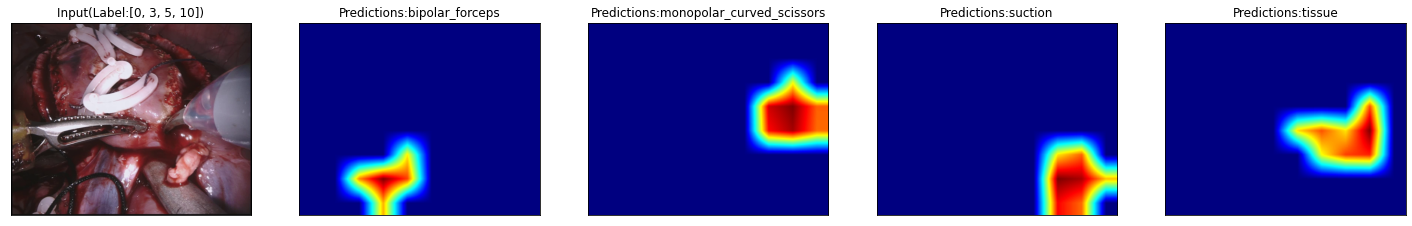

In [ ]:
import torch.nn as nn
from torch.nn import DataParallel
import torch.nn.functional as F
from torchvision import transforms as tf
from PIL import Image
import matplotlib.pyplot as plt
import cv2
#from torchvision import models

def reg_hook_gradcam():
    # gradients for gradcam are stored here
    stored_grads = torch.Tensor([])
    stored_fpass = torch.Tensor([])

    def bpass_hook(self, gin, gout):
        global stored_grads
        stored_grads = gout

    def fpass_hook(self, ten_in, ten_out):
        global stored_fpass
        stored_fpass = ten_out

    # register hooks for gradCAM model.layer4[-1].conv1
    #last_conv_layer = model.model.features.denseblock4.denselayer16.conv2
    last_conv_layer = model.layer4[2].conv3
    #last_conv_layer = model.layer4[-1].conv1
    handle_b = last_conv_layer.register_backward_hook(bpass_hook)
    handle_f = last_conv_layer.register_forward_hook(fpass_hook)


def get_gradcam(model, img, lab):
    reg_hook_gradcam()
    out, feature_map = model(img)
    out, feature_map = out.cpu(), feature_map.cpu()
    print('feature_map:',feature_map.shape)
    feature_map_pooled = F.adaptive_avg_pool3d(feature_map, [1,8,10]).squeeze().detach().numpy()
    print('feature_map_pooled:',feature_map_pooled.shape)
    feature_map = feature_map.squeeze()
    out = torch.sigmoid(out)
    true_labels = np.argwhere(lab.cpu()==1)[1]
    pred_labels = np.argwhere(out>0.5)[1]
    print('Probability:',[round(pro.item(), 3) for pro in out.squeeze()])
    #print('Labels:',[tl.item() for tl in true_labels],'Predictions:', [pl.item() for pl in pred_labels])
    pred_lab_each = F.one_hot(pred_labels, num_classes=11)
    #a = pred_lab_each[0]
    img_hmap = np.transpose(img.squeeze().cpu().numpy(),(1,2,0))
    supim_all = []
    heatmap_all = []
    feature_maps_all = []
    for a in pred_lab_each:
        #print(a.shape)
        out.backward(a[None], retain_graph=True)
        gradients = stored_grads[0].clone()
        activations = stored_fpass[0].clone().unsqueeze(0)
        activations = activations.detach()

        pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
        print('pooled_gradients', pooled_gradients.shape)
        for j in range(gradients.shape[1]):
            activations[:, j, :, :] *= pooled_gradients[j]

        print('activation', activations.shape)
        heatmap = torch.sum(activations, dim=1).squeeze().cpu()
        heatmap = np.maximum(heatmap, 0)
        heatmap /= torch.max(heatmap)
        print('min max', heatmap.min(), heatmap.max(), 'shape:', heatmap.shape)

        hmap = heatmap.numpy()
        hmap[hmap<0.60] = 0
        print('hmap',hmap.shape, 'feature_map_pooled',feature_map_pooled.shape, feature_map_pooled.max(), feature_map_pooled.min())
        hmap_rep = hmap[None].repeat(2048, axis=0)
        feature_map_class = feature_map[hmap_rep>0] #then pooling to 512
        print('feature_map_class:',feature_map_class.shape)
        feature_map_class_final = F.adaptive_avg_pool1d(torch.tensor(feature_map_class[None]),[512])
        print('feature_map_class_final:',feature_map_class_final.shape)
        feature_map_2d = feature_map.clone()
        feature_map_2d[hmap_rep==0] = 0
        feature_map_2d = feature_map_2d.mean(0)
        print('feature_map_2d mean:',feature_map_2d.shape)
        feature_map_2d_resized = cv2.resize(feature_map_2d.detach().numpy(), (img_hmap.shape[1], img_hmap.shape[0]))
        feature_maps_all.append(feature_map_2d_resized)
        # feature_map_2d = feature_map_pooled.copy()
        # feature_map_2d[hmap==0] = 0
        # feature_map_2d_resized = cv2.resize(feature_map_2d, (img_hmap.shape[1], img_hmap.shape[0]))
        # feature_maps_all.append(feature_map_2d_resized)

        heatmap1 = cv2.resize(hmap, (img_hmap.shape[1], img_hmap.shape[0]))
        heatmap1 = np.uint8(-255 * heatmap1 + 255)
        heatmap1 = cv2.applyColorMap(heatmap1, cv2.COLORMAP_JET)
        heatmap_all.append(heatmap1)
    return heatmap_all, pred_labels, true_labels, feature_maps_all, feature_map_class_final

model = resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 11)
model = DataParallel(model)
# model.to(device)
result_filename = 'combine_miccai18_ResNet50_256,320_170'
best_checkpoint_path = 'localization/' + result_filename + '_best_checkpoint.pth.tar'
checkpoint = torch.load(best_checkpoint_path, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint)
model = model.module
model.cuda();
model.eval()

for name, param in model.named_parameters():
    if param.requires_grad:
        if name.split('.')[1].isdigit():
            name = name.replace('.{}.'.format(name.split('.')[1]),'[{}].'.format(name.split('.')[1]))
            if name.split('.')[2].isdigit():
                name = name.replace('.{}.'.format(name.split('.')[2]),'[{}].'.format(name.split('.')[2]))

        my_code = 'model.'+ name + '.register_hook(lambda grad:grad.mul_(0))'
        exec(my_code)

image_name = "localization/1_frame146.png"   
classes = ['bipolar_forceps', 'prograsp_forceps', 'large_needle_driver', 'monopolar_curved_scissors', 'ultrasound_probe', 'suction', 'clip_applier', 'stapler', 'hook', 'specimen_bag', 'tissue']

'''------------------------------------- Load image ------------------------------------'''
image = Image.open(image_name).convert('RGB')
transforms = tf.Compose([tf.Resize((256,320)), 
                        tf.ToTensor(),
                        tf.Normalize([0.4084945, 0.25513682, 0.25353566], [0.22662906, 0.20201652, 0.1962526 ])])

img = transforms(image).cuda()
lab = torch.tensor([1,0,0,1,0,1,0,0,0,0,1])
img, lab = img[None], lab[None]
heatmap_all, pred_labels, true_labels, feature_maps_all, feature_map_class_final = get_gradcam(model, img, lab)

num_img = len(heatmap_all)+1
fig, ax = plt.subplots(1, num_img, figsize=(5*num_img,5), subplot_kw=dict(xticks=[],yticks=[]))
#ax[0].imshow(img[0].detach().permute(1,2,0).cpu())
ax[0].imshow(image)
ax[0].set_title('Input(Label:{})'.format([tl.item() for tl in true_labels]))

for idx, heatmap in enumerate(heatmap_all):
    ax[idx+1].imshow(heatmap)
    ax[idx+1].set_title('Predictions:{}'.format([classes[pl.item()] for pl in pred_labels][idx]))
